# Note about fixed effect in difference-in-differences with Python and R

See [did repo](https://github.com/vvoutilainen/Data_Science_Projects/tree/master/stats/did) for updated notebooks and source code.

In this note we cover in which way it is safe to include fixed effects (FEs) in difference-in-differences (DiD) model using Python *statsmodels*/*patsy* or R regression formulas.

**TLDR:**

It seems that in order to run DiD specification in Python or R, we need to dummy-code fixed effects by hand to be safe. Construction of dummies based on categorical fields cannot be left to *statsmodels*/*patsy* nor to R formulas.

## Imports

In [1]:
# Python dependencies
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
np.random.seed(1337)
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import patsy

# Local helpers
from did_helpers import simulate_did_data, plot_panel_data

# R interface
import rpy2
%load_ext rpy2.ipython

In [2]:
%%R
library(dagitty)

## Simulate data

Simulate panel data from the following data generating process:

\begin{align*}
    Y_{ijt}^0 &= \gamma_j + \xi_t + \epsilon_{it} \\
    Y_{ijt}^1 &= Y_{ijt}^0 + \tau \\
    Y_{ijt} &= D_{it} Y_{ijt}^1 + (1-D_{it}) Y_{ijt}^0
\end{align*}

where 

 - $Y_{ijt}^d$ denotes the observed outcome for individual *i* in gorup $j$ at time $t$;
 - $Y_{ijt}^d$ denotes the potential outcome under treatment status $d=0,1$;
 - $\gamma_j$ is a group-specific time-invariant confounding effect with $\gamma_C = 1$ and $\gamma_T=2$;
 - $\xi = t$ denotes common time fixed effect;
 - $\tau=-2$ is the effect of intervention;
 - $e_{it} \sim N(0, 1)$ denotes individual-time specific (idiosyncratic) effect.
 
We simulate data for 600 individuals at $t = 0, 1, \dots, 11$ time points. Intervention takes place between time points 5 and 6.

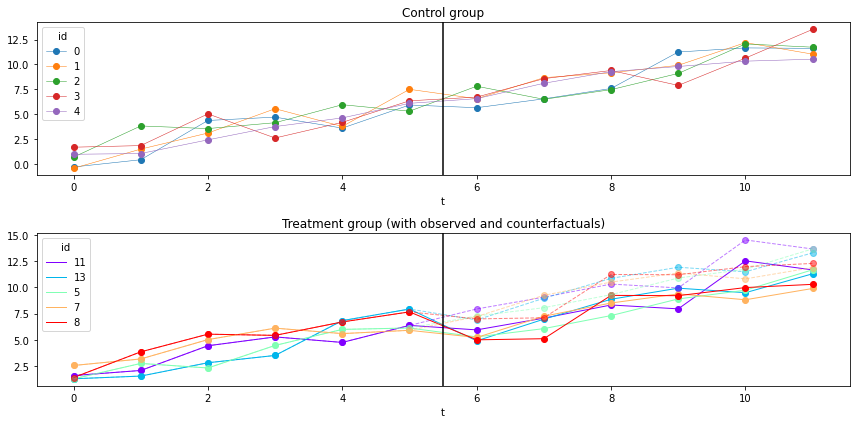

In [3]:
# Simulata data
out = simulate_did_data(
    param_datasettype="panel",
    param_no_t=12,
    param_gamma_c=1,
    param_gamma_t=2,
)

# Plot selected obseravtions
plot_panel_data(
    out,
    selected_individuals=\
        out["observed"].query("treatment_group=='control'")["id"].head(5).tolist() + \
        out["observed"].query("treatment_group=='treatment'")["id"].head(5).tolist()
)

## DiD design

Our difference-in-differences design can be illustrated with the following directed acyclical graph (DAG). We can use a DiD estimator controls to account for the group-specific confounding $\gamma_j$ and obtain an estimate for ATT (average treatment effect on the treated) estimand.

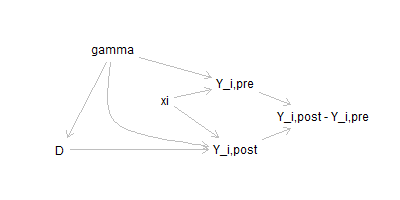

In [4]:
%%R -h 200 -w 400
g = dagitty('
    dag {
    " " [pos="-1.0, 0"]
    "" [pos="1.0, 1"]
    "D" [pos="-0.8, 0.8"]
    "Y_i,pre" [outcome,pos="0.2, 0.4"]
    "Y_i,post" [outcome,pos="0.2, 0.8"]
    "Y_i,post - Y_i,pre" [outcome,pos="0.7, 0.6"]
    "gamma" [adjusted,pos="-0.5, 0.2"]
    "xi" [pos="-0.2, 0.5"]
    "D" -> "Y_i,post"
    "gamma" -> "D"
    "gamma" -> "Y_i,post" [pos="-0.6, 0.7"]
    "gamma" -> "Y_i,pre"
    "Y_i,pre" <- "xi" -> "Y_i,post"
    "Y_i,pre" -> "Y_i,post - Y_i,pre" <- "Y_i,post"
    }
')
plot(g)

## DiD specifications with different fixed effects encodings

### Vanilla DiD using dummy-coding

When `treatment_group`, `time_group` as well as their interaction are coded as dummy variables, we get the correct DiD estimate and without multicolinearity issues. That is, this works fine!

In [5]:
def vanilla_did_with_dummies(data):
    
    df = data["observed"].copy()
    
    # Code categories as dummies
    df["time_group_dummy"] = df["time_group"].map({
        "before": 0,
        "post": 1,
    })
    df["treatment_group_dummy"] = df["treatment_group"].map({
        "control": 0,
        "treatment": 1,
    })
    df["treatment_time_dummy"] = df["treatment_group_dummy"] * df["time_group_dummy"]
    
    # Fit regression
    reg_str = "Y ~ 1 + time_group_dummy + treatment_group_dummy + treatment_time_dummy"
    res = smf.ols(reg_str, data=df).fit()
    print("Regression: {}\n".format(reg_str))
    print(res.summary())
    
    return df, reg_str

#### Python

In [6]:
df, reg_str = vanilla_did_with_dummies(out)

Regression: Y ~ 1 + time_group_dummy + treatment_group_dummy + treatment_time_dummy

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     3969.
Date:                Wed, 16 Aug 2023   Prob (F-statistic):               0.00
Time:                        12:22:44   Log-Likelihood:                -15091.
No. Observations:                7200   AIC:                         3.019e+04
Df Residuals:                    7196   BIC:                         3.022e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

#### R

In [7]:
%%R -i df,reg_str
summary(lm(reg_str, df))


Call:
lm(formula = reg_str, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.8566 -1.5015  0.0072  1.5118  6.3527 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)            3.50921    0.04711   74.49   <2e-16 ***
time_group_dummy       6.01550    0.06662   90.29   <2e-16 ***
treatment_group_dummy  0.99386    0.06565   15.14   <2e-16 ***
treatment_time_dummy  -2.05414    0.09284  -22.13   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.969 on 7196 degrees of freedom
Multiple R-squared:  0.6233,	Adjusted R-squared:  0.6231 
F-statistic:  3969 on 3 and 7196 DF,  p-value: < 2.2e-16



### Vanilla DiD using formulas

Works fine!

In [8]:
def vanilla_did_with_formula(data):
    
    df = data["observed"].copy()

    # Fit regression
    reg_str = "Y ~ 1 + time_group + treatment_group + treatment_group:time_group"
    res = smf.ols(reg_str, data=df).fit()
    print("Regression: {}\n".format(reg_str))
    print(res.summary())
    
    return df, reg_str

#### Python

In [9]:
df, reg_str = vanilla_did_with_formula(out)

Regression: Y ~ 1 + time_group + treatment_group + treatment_group:time_group

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     3969.
Date:                Wed, 16 Aug 2023   Prob (F-statistic):               0.00
Time:                        12:22:45   Log-Likelihood:                -15091.
No. Observations:                7200   AIC:                         3.019e+04
Df Residuals:                    7196   BIC:                         3.022e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------

#### R

In [10]:
%%R -i df,reg_str
summary(lm(reg_str, df))


Call:
lm(formula = reg_str, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.8566 -1.5015  0.0072  1.5118  6.3527 

Coefficients:
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                              3.50921    0.04711   74.49   <2e-16
time_grouppost                           6.01550    0.06662   90.29   <2e-16
treatment_grouptreatment                 0.99386    0.06565   15.14   <2e-16
time_grouppost:treatment_grouptreatment -2.05414    0.09284  -22.13   <2e-16
                                           
(Intercept)                             ***
time_grouppost                          ***
treatment_grouptreatment                ***
time_grouppost:treatment_grouptreatment ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.969 on 7196 degrees of freedom
Multiple R-squared:  0.6233,	Adjusted R-squared:  0.6231 
F-statistic:  3969 on 3 and 7196 DF,  p-value: < 2.2e-16



### Time FEs DiD using manual dummy-coding

Works fine!

In [11]:
def timefe_did_with_manual_dummies(data):
    
    df = data["observed"].copy()
    
    # Code categories as dummies
    df["time_group_dummy"] = df["time_group"].map({
        "before": 0,
        "post": 1,
    })
    df["treatment_group_dummy"] = df["treatment_group"].map({
        "control": 0,
        "treatment": 1,
    })
    df["treatment_time_dummy"] = df["treatment_group_dummy"] * df["time_group_dummy"]
    
    # Code time FEs as dummies
    df = pd.merge(
        df,
        pd.get_dummies(df["t"], prefix="t", prefix_sep="").astype("int64"),
        left_index=True,
        right_index=True,
    )
    
    # Fit regression
    reg_str = (
        "Y ~ 1 + t0 + t1 + t2 + t3 + t4 + t5 + t6 + t7 + t8 + t9 + "
        "t10 + t11 + treatment_group_dummy + treatment_time_dummy"
    )
    res = smf.ols(reg_str, data=df).fit()
    print("Regression: {}\n".format(reg_str))
    print(res.summary())
    
    return df, reg_str

#### Python

In [12]:
df, reg_str = timefe_did_with_manual_dummies(out)

Regression: Y ~ 1 + t0 + t1 + t2 + t3 + t4 + t5 + t6 + t7 + t8 + t9 + t10 + t11 + treatment_group_dummy + treatment_time_dummy

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     5198.
Date:                Wed, 16 Aug 2023   Prob (F-statistic):               0.00
Time:                        12:22:45   Log-Likelihood:                -10174.
No. Observations:                7200   AIC:                         2.038e+04
Df Residuals:                    7186   BIC:                         2.047e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025     

#### R

In [13]:
%%R -i df,reg_str
summary(lm(reg_str, df))


Call:
lm(formula = reg_str, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7139 -0.6574  0.0146  0.6663  3.8942 

Coefficients: (1 not defined because of singularities)
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            12.02874    0.04407  272.94   <2e-16 ***
t0                    -11.02283    0.06233 -176.86   <2e-16 ***
t1                    -10.00735    0.06233 -160.56   <2e-16 ***
t2                     -9.01756    0.06233 -144.68   <2e-16 ***
t3                     -7.98460    0.06233 -128.11   <2e-16 ***
t4                     -7.04355    0.06233 -113.01   <2e-16 ***
t5                     -6.04130    0.06233  -96.93   <2e-16 ***
t6                     -4.99564    0.05745  -86.96   <2e-16 ***
t7                     -3.99329    0.05745  -69.51   <2e-16 ***
t8                     -2.96353    0.05745  -51.58   <2e-16 ***
t9                     -2.03553    0.05745  -35.43   <2e-16 ***
t10                    -1.03623    0.05745

### Time FEs DiD using formulas

Now try coding the time FEs as a string variable in the regression formula. For group FE and group x period FE, use dummy coding still. Works fine!

In [14]:
def timefe_did_with_formula_1(data):
    
    df = data["observed"].copy()

    # Code categories as dummies
    df["time_group_dummy"] = df["time_group"].map({
        "before": 0,
        "post": 1,
    })
    df["treatment_group_dummy"] = df["treatment_group"].map({
        "control": 0,
        "treatment": 1,
    })
    df["treatment_time_dummy"] = df["treatment_group_dummy"] * df["time_group_dummy"]
    df["t"] = df["t"].astype(str)
    
    # Fit regression
    reg_str = "Y ~ -1 + t + treatment_group_dummy + treatment_time_dummy"
    res = smf.ols(reg_str, data=df).fit()
    print("Regression: {}\n".format(reg_str))
    print(res.summary())
    
    return df, reg_str

#### Python

In [15]:
df, _ = timefe_did_with_formula_1(out)

Regression: Y ~ -1 + t + treatment_group_dummy + treatment_time_dummy

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     5198.
Date:                Wed, 16 Aug 2023   Prob (F-statistic):               0.00
Time:                        12:22:46   Log-Likelihood:                -10174.
No. Observations:                7200   AIC:                         2.038e+04
Df Residuals:                    7186   BIC:                         2.047e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

#### R

In [16]:
%%R -i df
summary(lm("Y ~ -1 + t + treatment_group_dummy + treatment_time_dummy", df))


Call:
lm(formula = "Y ~ -1 + t + treatment_group_dummy + treatment_time_dummy", 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7139 -0.6574  0.0146  0.6663  3.8942 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
t0                     1.00591    0.04407   22.82   <2e-16 ***
t1                     2.02139    0.04407   45.87   <2e-16 ***
t10                   10.99251    0.04407  249.42   <2e-16 ***
t11                   12.02874    0.04407  272.94   <2e-16 ***
t2                     3.01118    0.04407   68.33   <2e-16 ***
t3                     4.04414    0.04407   91.76   <2e-16 ***
t4                     4.98520    0.04407  113.12   <2e-16 ***
t5                     5.98744    0.04407  135.86   <2e-16 ***
t6                     7.03311    0.04407  159.58   <2e-16 ***
t7                     8.03546    0.04407  182.33   <2e-16 ***
t8                     9.06521    0.04407  205.69   <2e-16 ***
t9                     9.99322    0.04

### Time FE DiD using formula and categoricals for all terms

Now try coding all terms as string variables in the regression formula.

**This is where we run into trouble!** Patsy/statsmodels does not realize to autimatocally from level *treatment_group[control]:time_group[T.post]* from the interaction term. This leads to multicolinearity issue with time FEs (see [How to Test for Multicollinearity in Python](https://www.statology.org/multicollinearity-in-python/)).

It is unknown to me why this happens and under *Vanilla DiD using formulas* things work just fine.

The problem seems to be that neither statsmodels/patsy or R formulas are smart enough to remove multicolinear columns automatically. That is, they do not understand that `t` absorbs `time_group` from multicolinearity issue alone, and nothing tells them that these columns are essentially telling the same thing. As per patsy documentation under [redundancy and categorical factors](https://patsy.readthedocs.io/en/latest/formulas.html#redundancy-and-categorical-factors): "*We’re only worried here about “structural redundancies”, those which occur inevitably no matter what the particular values occur in your data set. **If you enter two different factors x1 and x2, but set them to be numerically equal, then Patsy will indeed produce a design matrix that isn’t full rank. Avoiding that is your problem**.*"

While Python will show results for the interaction term (and the correct DiD estimate can be obtained when subtracting second level from the first), R will not even yield an estimate for the second level! It seems to be that Python/R regression leave freedom for the researcher by design, whereas Stata would automatically guide the user in a similar case.

#### Python

In [17]:
def timefe_did_with_formula_2(data):
    
    df = data["observed"].copy()
    df["t"] = df["t"].astype(str)
    
    # Fit regression
    reg_str = "Y ~ -1 + t + treatment_group + treatment_group:time_group"
    res = smf.ols(reg_str, data=df).fit()
    print("Regression: {}\n".format(reg_str))
    print(res.summary())
    
    return df, reg_str

In [18]:
df, reg_str = timefe_did_with_formula_2(out)

Regression: Y ~ -1 + t + treatment_group + treatment_group:time_group

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     5198.
Date:                Wed, 16 Aug 2023   Prob (F-statistic):               0.00
Time:                        12:22:47   Log-Likelihood:                -10174.
No. Observations:                7200   AIC:                         2.038e+04
Df Residuals:                    7186   BIC:                         2.047e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [19]:
# Check for the multicolinearity issue
X = patsy.dmatrices(reg_str, df, return_type="dataframe")[1]
print(pd.DataFrame({
    "variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
}))

                                         variable       VIF
0                                            t[0]  1.176976
1                                            t[1]  1.176976
2                                           t[10]       inf
3                                           t[11]       inf
4                                            t[2]  1.176976
5                                            t[3]  1.176976
6                                            t[4]  1.176976
7                                            t[5]  1.176976
8                                            t[6]       inf
9                                            t[7]       inf
10                                           t[8]       inf
11                                           t[9]       inf
12                   treatment_group[T.treatment]  2.000000
13    treatment_group[control]:time_group[T.post]       inf
14  treatment_group[treatment]:time_group[T.post]       inf


#### R

In [20]:
%%R -i df,reg_str
summary(lm(reg_str, df))


Call:
lm(formula = reg_str, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7139 -0.6574  0.0146  0.6663  3.8942 

Coefficients: (1 not defined because of singularities)
                                        Estimate Std. Error t value Pr(>|t|)
t0                                       1.00591    0.04407   22.82   <2e-16
t1                                       2.02139    0.04407   45.87   <2e-16
t10                                      8.93838    0.05487  162.91   <2e-16
t11                                      9.97461    0.05487  181.79   <2e-16
t2                                       3.01118    0.04407   68.33   <2e-16
t3                                       4.04414    0.04407   91.76   <2e-16
t4                                       4.98520    0.04407  113.12   <2e-16
t5                                       5.98744    0.04407  135.86   <2e-16
t6                                       4.97897    0.05487   90.75   <2e-16
t7                                      

### Further checks

Below are some alternative was to specify the terms as categorical variables, but the same problem persists: statsmodels/patsy does not know that unit/time FEs are related with the interaction term and is not smart enough to infer it from multicolinearity alone.

In [21]:
def alternative_did_specs(data):

    df = data["observed"].copy()
    
    # Code variables as categoricals
    df["treatment_time_group"] = df["treatment_group"] + "_" + df["time_group"]
    df["t"] = pd.Categorical(df["t"], ordered=True)
    df["treatment_group"] = pd.Categorical(
        df["treatment_group"], categories=["control", "treatment"], ordered=True
    )
    df["treatment_time_group"] = pd.Categorical(df["treatment_time_group"], ordered=False)
        
    # Alternative 1
    reg_str = "Y ~ -1 + t + treatment_group + treatment_group:time_group"
    res = smf.ols(reg_str, data=df).fit()
    print("Regression: {}\n".format(reg_str))
    print(res.summary())
    print("\n")
    
    # Alternative 2
    reg_str = "Y ~ -1 + t + treatment_group + treatment_time_group"
    res = smf.ols(reg_str, data=df).fit()
    print("Regression: {}\n".format(reg_str))
    print(res.summary())
    print("\n")

In [22]:
alternative_did_specs(out)

Regression: Y ~ -1 + t + treatment_group + treatment_group:time_group

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     5198.
Date:                Wed, 16 Aug 2023   Prob (F-statistic):               0.00
Time:                        12:22:48   Log-Likelihood:                -10174.
No. Observations:                7200   AIC:                         2.038e+04
Df Residuals:                    7186   BIC:                         2.047e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------